In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, BartTokenizer,BartForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import os
import matplotlib.pyplot as plt


In [2]:
# Prototype option:
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # Set a fallback to CPU if MPS is not yet implemented

# Assign cuda to the device to use for training
if torch.cuda.is_available(): 
 dev = "cuda:0" 
 print("This model will run on CUDA")
# elif  torch.backends.mps.is_available(): 
#  dev = "mps:0"
#  print("This model will run on MPS")
else:
 dev = "cpu" 
 print("This model will run on CPU")
device = torch.device(dev) 

This model will run on CUDA


In [8]:
# Load the desired model and tokenizer
model_name = "BART_TUNED_MDN_20K_v2"
output_dir = f"../7. Models/{model_name}/"
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model = BartForConditionalGeneration.from_pretrained(output_dir).to(device)
tokenizer = BartTokenizer.from_pretrained(output_dir)

In [9]:
# Load the validation dataset
val_file = f'./../3. Cleaned Data/MDN_20K_v2_val.csv'
val_df = pd.read_csv(val_file)

# During initial testing, will only choose 50 for speed
val_df = val_df.sample(50, random_state=123).reset_index()

In [10]:
# Function to generate predictions using the model
def generate_prediction(prompt, max_length=100, temperature=1.0, top_p=1.0):
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=device)
    with torch.no_grad():
        output = model.generate(
            input_ids, 
            attention_mask=attention_mask, 
            max_length=max_length, 
            num_return_sequences=1, 
            no_repeat_ngram_size=2,
            temperature=temperature,
            top_p=top_p,
        )
    return tokenizer.decode(output[0], skip_special_tokens=True)


In [11]:
# Calculate BLEU score and cosine distance
bleu_scores = []
cosine_distances = []

vectorizer = TfidfVectorizer()

In [26]:
for index, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    original = row['original']
    corrected = row['corrected']

    # Set max_length dynamically based on the length of the original text
    prompt = f"input: {original} output:"
    prompt_length = len(tokenizer.encode(prompt))
    dynamic_max_length = int(1.5 * len(original.split())) + prompt_length
    print(dynamic_max_length)

    # Generate prediction
    prediction = generate_prediction(prompt, max_length=dynamic_max_length, temperature=0.8, top_p=0.8)

    # Extract the actual generated output
    if len(prediction) >= 2:
        generated_output = prediction.split("output:")[0].strip()
    else:
        generated_output = ""
    #generated_output = prediction.split("output:")[1].strip()

    # Save the generated output
    val_df.loc[index, 'predicted'] = generated_output

    # Calculate BLEU score
    bleu_score = sentence_bleu([corrected.split()], generated_output.split(), weights=(0.33, 0.33, 0.33))

    # Save the BLEU score
    val_df.loc[index, 'BLEU'] = bleu_score

    # Calculate cosine distance
    vector_matrix = vectorizer.fit_transform([corrected, generated_output])
    cosine_distance = cosine_similarity(vector_matrix[0:1], vector_matrix[1:2])[0][0]

    # Save the cosine distance
    val_df.loc[index, 'cosine'] = cosine_distance


  0%|          | 0/50 [00:00<?, ?it/s]/home/timlinux/anaconda3/envs/llama/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/timlinux/anaconda3/envs/llama/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
  2%|▏         | 1/50 [00:00<00:05,  8.29it/s]

25
29


  4%|▍         | 2/50 [00:00<00:05,  8.51it/s]

64


  8%|▊         | 4/50 [00:00<00:06,  6.67it/s]

32
70


 14%|█▍        | 7/50 [00:01<00:05,  7.33it/s]

20
25
32


 16%|█▌        | 8/50 [00:01<00:05,  7.59it/s]

73


 20%|██        | 10/50 [00:01<00:05,  6.93it/s]

27
41


 22%|██▏       | 11/50 [00:01<00:05,  6.82it/s]

17
49


 28%|██▊       | 14/50 [00:02<00:04,  7.25it/s]

46
41


 30%|███       | 15/50 [00:02<00:05,  6.99it/s]

65


 34%|███▍      | 17/50 [00:02<00:04,  6.81it/s]

33
36


 38%|███▊      | 19/50 [00:02<00:04,  6.70it/s]

66
48


 42%|████▏     | 21/50 [00:03<00:04,  6.89it/s]

35
32


 44%|████▍     | 22/50 [00:03<00:03,  7.42it/s]

106


 48%|████▊     | 24/50 [00:03<00:04,  5.68it/s]

32
27


 50%|█████     | 25/50 [00:03<00:03,  6.38it/s]

19
27


 54%|█████▍    | 27/50 [00:03<00:03,  7.50it/s]

84


 56%|█████▌    | 28/50 [00:04<00:03,  6.49it/s]

100


 60%|██████    | 30/50 [00:04<00:03,  6.16it/s]

30
52


 64%|██████▍   | 32/50 [00:04<00:02,  6.49it/s]

35
34


 68%|██████▊   | 34/50 [00:05<00:02,  6.33it/s]

55
45


 70%|███████   | 35/50 [00:05<00:02,  5.85it/s]

66


 74%|███████▍  | 37/50 [00:05<00:02,  5.43it/s]

54
29
106


 80%|████████  | 40/50 [00:06<00:01,  6.01it/s]

20
37


 84%|████████▍ | 42/50 [00:06<00:01,  6.38it/s]

61
72


 88%|████████▊ | 44/50 [00:06<00:00,  6.46it/s]

42
80


 92%|█████████▏| 46/50 [00:07<00:00,  5.90it/s]

41
27


 96%|█████████▌| 48/50 [00:07<00:00,  7.33it/s]

30
68


100%|██████████| 50/50 [00:07<00:00,  6.43it/s]

25


In [27]:
outputs = val_df[['original','corrected','predicted','BLEU','cosine']]

In [28]:
val_df.head()

,index,Unnamed: 0,original,corrected,predicted,BLEU,cosine
0,1342,7783,Rainforest is significant habitats for wild an...,Rain forest provides significant habitats for ...,input Rain is habitats wild.forest significant...,7.077949e-204,0.550780
1,1338,51850,Now I manage to know more about our company.,Now I am learning more about our company.,input Now manage know about company,4.436418e-204,0.304126
2,189,69991,Some people change their jobs and homes freque...,Some people change their jobs and homes freque...,: people their their and frequently while peop...,5.071572e-204,0.572094
3,1332,8677,"I plant rose of three colors, blue, green, pink.","I planted roses of three colors blue, green, a...",input I rose three colors blue green pink,8.842967e-103,0.465292
4,1816,6370,"At that time,all high school teachers told us,...","At that time,all high school teachers told us,...","Input At timeall school told, study for yearaf...",2.451789e-204,0.286697


In [30]:
val_gen = f'./../3. Cleaned Data/{model_name}_val_gen_test.csv'
outputs.to_csv(val_gen)

In [29]:
# Calculate the average BLEU score
average_bleu = val_df['BLEU'].mean()
print(f"Average BLEU score: {average_bleu}")

# Calculate the average cosine similarity
average_cosine = val_df['cosine'].mean()
print(f"Average cosine similarity: {average_cosine}")

Average BLEU score: 2.23945775563217e-103
Average cosine similarity: 0.40971702569273805


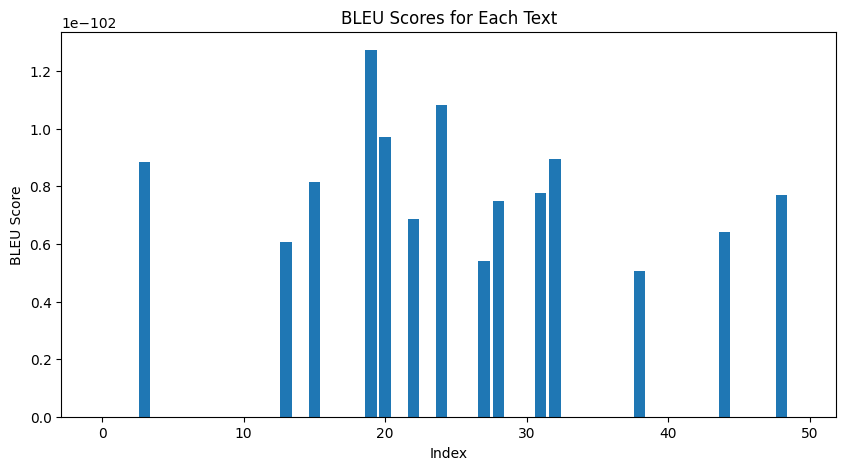

In [31]:
# Bar plot of BLEU scores
plt.figure(figsize=(10, 5))
plt.bar(val_df.index, val_df['BLEU'])
plt.xlabel('Index')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for Each Text')
plt.show()

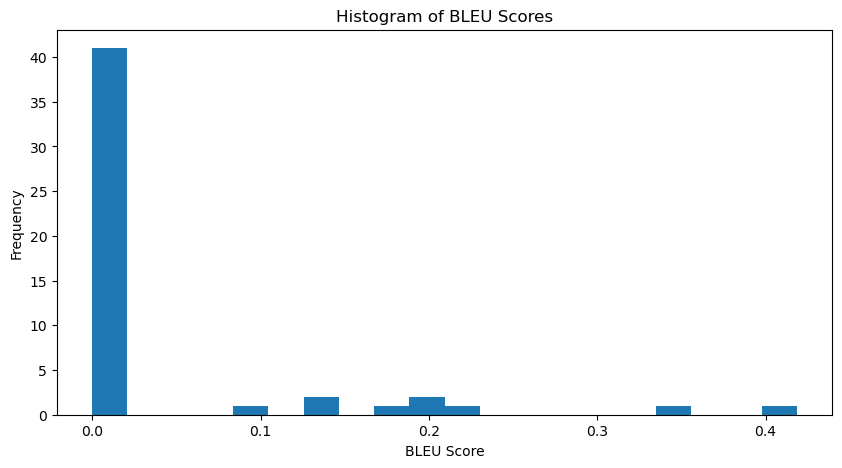

In [ ]:
# Histogram of BLEU scores
plt.figure(figsize=(10, 5))
plt.hist(val_df['BLEU'], bins=20)
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Histogram of BLEU Scores')
plt.show()

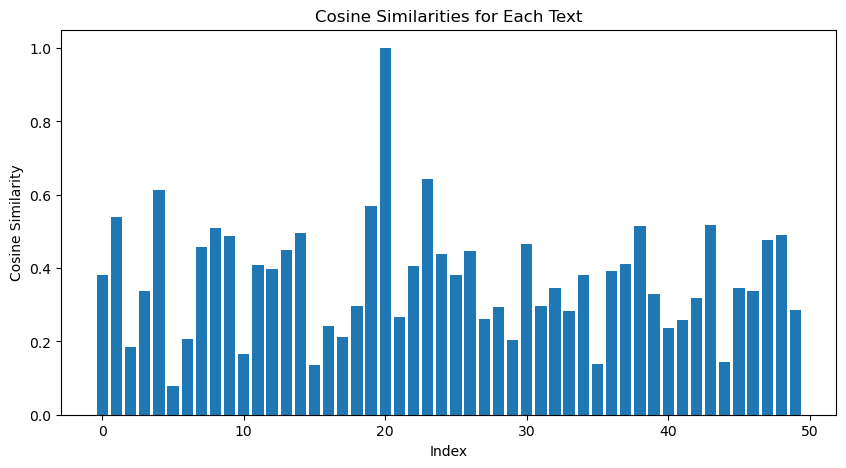

In [ ]:

# Bar plot of cosine similarities
plt.figure(figsize=(10, 5))
plt.bar(val_df.index, val_df['cosine'])
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarities for Each Text')
plt.show()

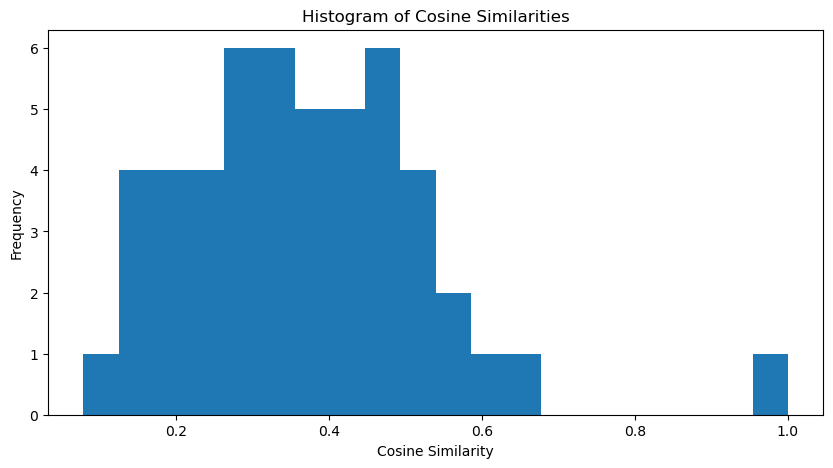

In [ ]:
# Histogram of cosine similarities
plt.figure(figsize=(10, 5))
plt.hist(val_df['cosine'], bins=20)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')
plt.show()